In [ ]:
# 0. Install dependencies
!pip install -q datasets scikit-learn matplotlib

In [ ]:
# 1. Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#2. Load SensorCaps dataset
ds = load_dataset("BASH-Lab/SensorCaps")
print("Dataset splits:", ds)

# Choose first available split (usually 'train')
split_name = "train" if "train" in ds else list(ds.keys())[0]
data = ds[split_name]
print(f"Using split: {split_name}, num samples: {len(data)}")

# Inspect first example (for your understanding; optional)
example = data[0]
print("Example keys:", example.keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/hhar_v1-00000-of-00001.jsonl:   0%|          | 0.00/57.0M [00:00<?, ?B/s]

data/hhar_v2-00000-of-00001.jsonl:   0%|          | 0.00/415M [00:00<?, ?B/s]

data/motion_v1-00000-of-00001.jsonl:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

data/motion_v2-00000-of-00001.jsonl:   0%|          | 0.00/207M [00:00<?, ?B/s]

data/pamap2_v2-00000-of-00001.jsonl:   0%|          | 0.00/453M [00:00<?, ?B/s]

data/shoaib_v1-00000-of-00001.jsonl:   0%|          | 0.00/63.5M [00:00<?, ?B/s]

data/shoaib_v2-00000-of-00001.jsonl:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/uci_v1-00000-of-00001.jsonl:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

data/uci_v2-00000-of-00001.jsonl:   0%|          | 0.00/92.5M [00:00<?, ?B/s]

Generating hhar_v1 split:   0%|          | 0/9166 [00:00<?, ? examples/s]

Generating hhar_v2 split:   0%|          | 0/9166 [00:00<?, ? examples/s]

Generating motion_v1 split:   0%|          | 0/4534 [00:00<?, ? examples/s]

Generating motion_v2 split:   0%|          | 0/4534 [00:00<?, ? examples/s]

Generating pamap2_v2 split:   0%|          | 0/9672 [00:00<?, ? examples/s]

Generating shoaib_v1 split:   0%|          | 0/10500 [00:00<?, ? examples/s]

Generating shoaib_v2 split:   0%|          | 0/10500 [00:00<?, ? examples/s]

Generating uci_v1 split:   0%|          | 0/2088 [00:00<?, ? examples/s]

Generating uci_v2 split:   0%|          | 0/2088 [00:00<?, ? examples/s]

Dataset splits: DatasetDict({
    hhar_v1: Dataset({
        features: ['messages'],
        num_rows: 9166
    })
    hhar_v2: Dataset({
        features: ['messages'],
        num_rows: 9166
    })
    motion_v1: Dataset({
        features: ['messages'],
        num_rows: 4534
    })
    motion_v2: Dataset({
        features: ['messages'],
        num_rows: 4534
    })
    pamap2_v2: Dataset({
        features: ['messages'],
        num_rows: 9672
    })
    shoaib_v1: Dataset({
        features: ['messages'],
        num_rows: 10500
    })
    shoaib_v2: Dataset({
        features: ['messages'],
        num_rows: 10500
    })
    uci_v1: Dataset({
        features: ['messages'],
        num_rows: 2088
    })
    uci_v2: Dataset({
        features: ['messages'],
        num_rows: 2088
    })
})
Using split: hhar_v1, num samples: 9166
Example keys: dict_keys(['messages'])


In [ ]:
#3. Helper functions: parse messages
def extract_user_message(example):
    """
    From one sample, return the 'user' role message content (string).
    """
    msgs = example.get("messages", [])
    for m in msgs:
        if m.get("role") == "user":
            return m.get("content", "")
    return None




In [ ]:

    """
    From user message text, extract:
      - summary (string)
      - gyro (np.array of shape (T, 3))
      - acc  (np.array of shape (T, 3))
    """

'\nFrom user message text, extract:\n  - summary (string)\n  - gyro (np.array of shape (T, 3))\n  - acc  (np.array of shape (T, 3))\n'

In [ ]:
 # Extract summary line
def parse_message_to_fields(msg_text):
  """
    From user message text, extract:
      - summary (string)
      - gyro (np.array of shape (T, 3))
      - acc  (np.array of shape (T, 3))
    """
  summary_match = re.search(r"Summary:\s*([^\n]+)",msg_text)
  summary = summary_match.group(1).strip() if summary_match else "unknown"
  gyro_match = re.search(r"Gyroscope:\s*(\[\[.*?\]\])", msg_text, re.S)
  acc_match  = re.search(r"Accelerometer:\s*(\[\[.*?\]\])", msg_text, re.S)
  if not gyro_match or not acc_match:
        raise ValueError("Could not parse Gyroscope / Accelerometer from message.")

  gyro_str = gyro_match.group(1)
  acc_str  = acc_match .group(1)
  # Convert string representation to numpy arrays
  gyro = np.array(eval(gyro_str), dtype=float)  # (T, 3)
  acc  = np.array(eval(acc_str),  dtype=float)  # (T, 3)

  return summary, gyro, acc




In [ ]:
# Quick sanity check on one sample
msg0 = extract_user_message(example)
summary0, gyro0, acc0 = parse_message_to_fields(msg0)
print("Sample summary:", summary0)
print("Gyro shape:", gyro0.shape, "Acc shape:", acc0.shape)


Sample summary: standing
Gyro shape: (60, 3) Acc shape: (60, 3)


In [ ]:
#4. IMU feature extraction
def imu_feature_vector(acc, gyro):
    """
    acc, gyro: numpy arrays of shape (T, 3)
    Returns: 1D feature vector with statistics from both sensors.
    """
    feats = []

    def stats_for_matrix(mat):
        # Per-axis stats
        for i in range(3):
            col = mat[:, i]
            feats.extend([
                np.mean(col),
                np.std(col),
                np.min(col),
                np.max(col),
                np.percentile(col, 25),
                np.percentile(col, 75),
                skew(col),
                kurtosis(col),
                np.sum(col**2)  # energy
            ])

        # Correlations between axes
        for (i, j) in [(0, 1), (0, 2), (1, 2)]:
            corr = np.corrcoef(mat[:, i], mat[:, j])[0, 1]
            feats.append(corr)

        # Magnitude-based stats
        mag = np.linalg.norm(mat, axis=1)
        feats.extend([
            np.mean(mag),
            np.std(mag),
            np.sum(np.abs(mag))
        ])

        # Jerk features: change in magnitude
        diff = np.abs(np.diff(mag))
        if len(diff) == 0:
            feats.extend([0.0, 0.0])
        else:
            feats.append(np.mean(diff))
            big_change_thresh = np.percentile(diff, 75)
            feats.append(np.sum(diff > big_change_thresh))

    # Accelerometer features then gyroscope features
    stats_for_matrix(acc)
    stats_for_matrix(gyro)

    return np.array(feats, dtype=float)
    # Test feature size
    fv0 = imu_feature_vector(acc0, gyro0)
    print("One feature vector length:", len(fv0))

In [ ]:
#5. Cognitive load heuristic from Summary text
COG_WORDS = [
    "typing", "reading", "coding", "studying", "writing",
    "analyzing", "solving", "calculating", "exam", "planning"
]

MULTISTEP_WORDS = [
    "while", "and then", "at the same time", "simultaneously"
]

def cognitive_level(text):
    """
    Simple heuristic: outputs 'Low', 'Medium', or 'High' cognitive load
    from the activity summary text.
    """
    if text is None:
        return "Low"
    t = text.lower()
    words = t.split()
    score = 0

    # More words → more complex activity description
    if len(words) >= 3:
        score += 1
    # Contains cognitively heavy verbs
    if any(w in t for w in COG_WORDS):
        score += 1
    # Indicates multitasking / multi-step actions
    if any(phrase in t for phrase in MULTISTEP_WORDS):
        score += 1

    if score == 0:
        return "Low"
    elif score == 1:
        return "Medium"
    else:
        return "High"

print("Cognitive load examples:")
print("standing  →", cognitive_level("standing"))
print("typing a report while reading notes  →",
      cognitive_level("typing a report while reading notes"))

Cognitive load examples:
standing  → Low
typing a report while reading notes  → High


In [ ]:
# 6. Build full feature matrix + physical scores
X_list = []
summaries = []
phys_score_list = []
n_failed = 0

for i, ex in enumerate(data):
    user_msg = extract_user_message(ex)
    if user_msg is None:
        n_failed += 1
        continue

    try:
        summary, gyro, acc = parse_message_to_fields(user_msg)
    except Exception as e:
        n_failed += 1
        continue

    # IMU features
    fv = imu_feature_vector(acc, gyro)
    X_list.append(fv)
    summaries.append(summary)

    # Simple physical load score: mean magnitude of acc + gyro
    acc_mag = np.linalg.norm(acc, axis=1)
    gyro_mag = np.linalg.norm(gyro, axis=1)
    phys_score = np.mean(acc_mag) + np.mean(gyro_mag)
    phys_score_list.append(phys_score)

    if (i + 1) % 2000 == 0:
        print(f"Processed {i+1}/{len(data)} samples...")

X = np.vstack(X_list)
phys_scores = np.array(phys_score_list)

print("\nTotal usable samples:", len(X_list))
print("Failed/Skipped samples:", n_failed)
print("Feature matrix shape:", X.shape)
print("First 5 summaries:", summaries[:5])



Processed 2000/9166 samples...
Processed 4000/9166 samples...
Processed 6000/9166 samples...
Processed 8000/9166 samples...

Total usable samples: 9166
Failed/Skipped samples: 0
Feature matrix shape: (9166, 70)
First 5 summaries: ['standing', 'standing', 'standing', 'standing', 'standing']


In [ ]:
# 7. Physical load levels (Low / Medium / High)
p33 = np.percentile(phys_scores, 33)
p66 = np.percentile(phys_scores, 66)
print("\nPhysical score percentiles: 33% =", p33, ", 66% =", p66)

def physical_level(score):
    if score <= p33:
        return "Low"
    elif score <= p66:
        return "Medium"
    else:
        return "High"

phys_levels = [physical_level(s) for s in phys_scores]
print("Physical level counts:\n", pd.Series(phys_levels).value_counts())


Physical score percentiles: 33% = 10.08121581372103 , 66% = 10.693584452613129
Physical level counts:
 High      3117
Low       3025
Medium    3024
Name: count, dtype: int64


In [ ]:
# 8. Cognitive levels from summaries
cog_levels = [cognitive_level(s) for s in summaries]
print("\nCognitive level counts:\n", pd.Series(cog_levels).value_counts())


Cognitive level counts:
 Low    9166
Name: count, dtype: int64


In [ ]:
# 9. Build 4 stress-type labels
def stress_class(phys, cog):
    """
    4-class stress-type definition:
      - LowStress
      - CognitiveHigh
      - PhysicalHigh
      - HighHigh
    """
    if phys == "Low" and cog == "Low":
        return "LowStress"
    elif phys in ["Low", "Medium"] and cog == "High":
        return "CognitiveHigh"
    elif phys == "High" and cog in ["Low", "Medium"]:
        return "PhysicalHigh"
    elif phys == "High" and cog == "High":
        return "HighHigh"
    else:
        # e.g., phys=Medium, cog=Medium → treat as LowStress (moderate)
        return "LowStress"

y_labels = [stress_class(p, c) for p, c in zip(phys_levels, cog_levels)]
print("\nStress class counts:\n", pd.Series(y_labels).value_counts())
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)
print("Encoded classes:", list(le.classes_))


Stress class counts:
 LowStress       6049
PhysicalHigh    3117
Name: count, dtype: int64
Encoded classes: [np.str_('LowStress'), np.str_('PhysicalHigh')]


In [ ]:
# 10. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (7332, 70) Test shape: (1834, 70)


In [ ]:
# 11. Define 5 models
models = {
    "LogReg": LogisticRegression(
        max_iter=1000,
        multi_class="multinomial"
    ),
    "LDA": LinearDiscriminantAnalysis(),
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "SVM_RBF": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42
    )
}


In [ ]:
# 12. Cross-validation + test evaluation
results = {}
best_pipes = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    cv_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv,
        scoring="accuracy"
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print("\n" + "="*50)
    print(f"Model: {name}")
    print("CV Accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))
    print("\nTest set classification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "y_pred": y_pred,
        "cm": cm
    }
    best_pipes[name] = pipe

# Summarise CV results in a small table
summary_rows = []
for name, res in results.items():
    summary_rows.append({
        "Model": name,
        "CV_Accuracy_Mean": res["cv_mean"],
        "CV_Accuracy_Std": res["cv_std"]
    })
results_df = pd.DataFrame(summary_rows).sort_values("CV_Accuracy_Mean", ascending=False)
print("\n\n=== Cross-validation summary ===")
print(results_df.to_string(index=False))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w


Model: LogReg
CV Accuracy: 0.9930 ± 0.0012

Test set classification report:
              precision    recall  f1-score   support

   LowStress       1.00      1.00      1.00      1210
PhysicalHigh       0.99      0.99      0.99       624

    accuracy                           0.99      1834
   macro avg       0.99      0.99      0.99      1834
weighted avg       0.99      0.99      0.99      1834


Model: LDA
CV Accuracy: 0.9476 ± 0.0049

Test set classification report:
              precision    recall  f1-score   support

   LowStress       0.96      0.97      0.97      1210
PhysicalHigh       0.94      0.93      0.94       624

    accuracy                           0.96      1834
   macro avg       0.95      0.95      0.95      1834
weighted avg       0.96      0.96      0.96      1834


Model: kNN
CV Accuracy: 0.9587 ± 0.0051

Test set classification report:
              precision    recall  f1-score   support

   LowStress       0.96      0.97      0.97      1210
PhysicalHigh


Confusion matrix for LogReg:


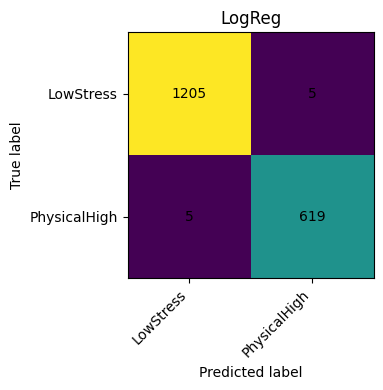


Confusion matrix for LDA:


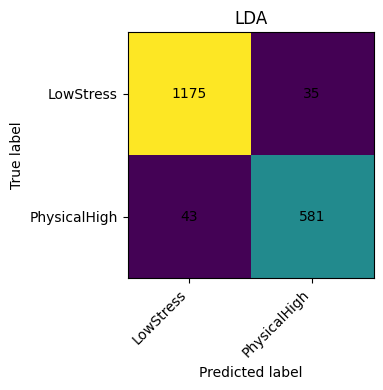


Confusion matrix for kNN:


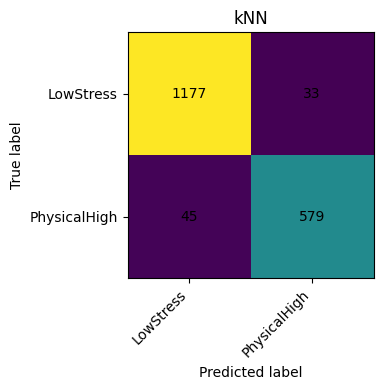


Confusion matrix for SVM_RBF:


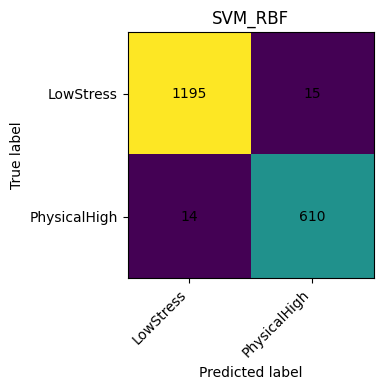


Confusion matrix for RandomForest:


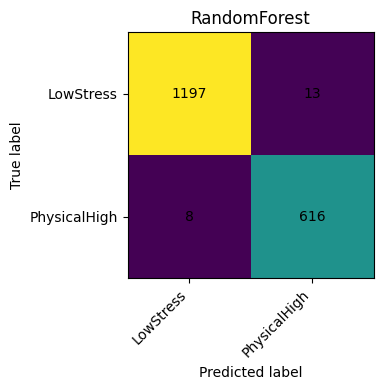

In [ ]:
# 13. Confusion matrices
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    # show numbers
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center")

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

for name, res in results.items():
    print(f"\nConfusion matrix for {name}:")
    plot_confusion_matrix(res["cm"], le.classes_, title=name)

In [ ]:
# 14. Simple recommendation engine demo
def recommend(label):
    if label == "LowStress":
        return ("Activity appears low stress. Maintain current routine, "
                "use basic warm-up and occasional short breaks.")
    elif label == "CognitiveHigh":
        return ("High cognitive load detected. Reduce multitasking, "
                "take short mental breaks and focus on one task at a time.")
    elif label == "PhysicalHigh":
        return ("High physical load detected. Reduce intensity, check posture, "
                "and schedule recovery periods to avoid fatigue or strain.")
    elif label == "HighHigh":
        return ("Very high combined physical and cognitive stress. Stop the activity, "
                "rest properly, stretch and use breathing exercises before continuing.")
    else:
        return "No recommendation available."

# Use the best-performing model (by CV accuracy)
best_model_name = results_df.iloc[0]["Model"]
best_pipe = best_pipes[best_model_name]
print("\nBest model by CV accuracy:", best_model_name)

print("\n ***Recommendation examples from test set ***")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    x_sample = X_test[idx:idx+1]
    true_label = le.classes_[y_test[idx]]
    pred_idx = best_pipe.predict(x_sample)[0]
    pred_label = le.classes_[pred_idx]

    print("\nSample", i+1)
    print("True label:", true_label)
    print("Predicted :", pred_label)
    print("Recommendation:", recommend(pred_label))



Best model by CV accuracy: LogReg

 ***Recommendation examples from test set ***

Sample 1
True label: PhysicalHigh
Predicted : PhysicalHigh
Recommendation: High physical load detected. Reduce intensity, check posture, and schedule recovery periods to avoid fatigue or strain.

Sample 2
True label: PhysicalHigh
Predicted : PhysicalHigh
Recommendation: High physical load detected. Reduce intensity, check posture, and schedule recovery periods to avoid fatigue or strain.

Sample 3
True label: LowStress
Predicted : LowStress
Recommendation: Activity appears low stress. Maintain current routine, use basic warm-up and occasional short breaks.

Sample 4
True label: LowStress
Predicted : LowStress
Recommendation: Activity appears low stress. Maintain current routine, use basic warm-up and occasional short breaks.

Sample 5
True label: LowStress
Predicted : LowStress
Recommendation: Activity appears low stress. Maintain current routine, use basic warm-up and occasional short breaks.
